## Sentiment to Strategy: Leveraging Forums Discussions to Guide Automated Trading Decisions 

---

### 0. Importing libraries

In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import praw
import csv
import time
from datetime import datetime, timedelta
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
import string
import io, contextlib
import yfinance as yf   
from pathlib import Path
import locale
from matplotlib import ticker
import matplotlib.dates as mdates

---

### 1. Reddit API Data Extraction and Manipulation

In [37]:
# Initialize PRAW (Python Reddit API Wrapper)
user_agent = "StockMarket Sentiment Analysis"
reddit = praw.Reddit(
    client_id="SDD6BO5WvswKQ2DOZrioiQ",
    client_secret="BoGTdq9xg1Wu4kjy3zj_WBLbTInQvQ",
    user_agent=user_agent
)

# Initialize the subreddit
subreddit = reddit.subreddit("wallstreetbets")

In [38]:
# List to hold data for each post
posts = []

# Fetch posts from the subreddit
for submission in subreddit.new(limit=None):
    post_date = datetime.fromtimestamp(submission.created_utc)
    posts.append({
        'id': submission.id,
        'title': submission.title,
        'selftext': submission.selftext,
        'score': submission.score,
        'upvote_ratio': submission.upvote_ratio,       
        'created_date': post_date,
        'permalink': f"https://redd.it/{submission.id}"
    })

# Convert the list to a DataFrame
raw_df = pd.DataFrame(posts)
raw_df

,id,title,selftext,score,upvote_ratio,created_date,permalink
0,1kzioch,All or Nothing,Well.. after DICKS and CRM fucking me this wee...,1,1.00,2025-05-31 01:24:39,https://redd.it/1kzioch
1,1kzijm4,First year trading,This is my first year trading. Started with ar...,3,0.80,2025-05-31 01:18:49,https://redd.it/1kzijm4
2,1kziji9,Shout out to all the bad girls for spending th...,I finally got one right on to the next move,13,0.93,2025-05-31 01:18:41,https://redd.it/1kziji9
3,1kzifi2,No One Is Safe,"""No One Is Safe""\nWhen the circus hits Wall St...",0,0.47,2025-05-31 01:13:39,https://redd.it/1kzifi2
4,1kzhypv,Ford,I’m coming back from a long break. I’ve seen r...,0,0.40,2025-05-31 00:52:37,https://redd.it/1kzhypv
...,...,...,...,...,...,...,...
828,1kh6srs,How are we feeling about NVDA leading up to th...,Debating the play on NVDA ahead of the earning...,31,0.84,2025-05-07 21:53:08,https://redd.it/1kh6srs
829,1kh6pky,Trump to Rescind Global Chip Curbs Amid AI Res...,https://blinks.bloomberg.com/news/stories/SVW6...,484,0.95,2025-05-07 21:49:23,https://redd.it/1kh6pky
830,1kh6mps,"Jeremy Barnum, CFO of JPM, just cut his holdin...",Insider buying and selling isn't always a grea...,199,0.93,2025-05-07 21:46:06,https://redd.it/1kh6mps
831,1kh67c2,Summary of today's Fed decision and press conf...,,1047,0.99,2025-05-07 21:28:18,https://redd.it/1kh67c2


In [39]:
# Create a csv file with the data
if os.path.exists('wsb_posts.csv'):
    existing_df = pd.read_csv('wsb_posts.csv')
    combined_df = pd.concat([existing_df, raw_df]).drop_duplicates(subset=['id'])
    combined_df.to_csv('wsb_posts.csv', index=False)
else:
    raw_df.to_csv('wsb_posts.csv', index=False)

In [40]:
# Load the data from the csv file
df = pd.read_csv('wsb_posts.csv')
df

,id,title,selftext,score,upvote_ratio,created_date,permalink,text
0,1kqotlw,Whats your opinion about Rocket Lab?,I see many ppl hyping rocket lab and also boug...,1,1.00,2025-05-20 00:12:16,https://redd.it/1kqotlw,Whats your opinion about Rocket Lab? I see man...
1,1kqoadm,Fed's Powell has sounded the alarm for years a...,NaN,125,0.94,2025-05-19 23:49:38,https://redd.it/1kqoadm,Fed's Powell has sounded the alarm for years a...
2,1kqo5u3,Big beautiful bill,Am I screwed with my sp500 ETFs as a French in...,0,0.25,2025-05-19 23:44:20,https://redd.it/1kqo5u3,Big beautiful bill Am I screwed with my sp500 ...
3,1kqo1xz,Question on UNH Stock,"Should I sell UNH calls, covered calls or hold...",11,0.87,2025-05-19 23:39:50,https://redd.it/1kqo1xz,"Question on UNH Stock Should I sell UNH calls,..."
4,1kqmxov,Is this gonna print tomorrow,"Held these over the weekend, at its peak today...",0,0.44,2025-05-19 22:54:47,https://redd.it/1kqmxov,Is this gonna print tomorrow Held these over t...
...,...,...,...,...,...,...,...,...
1343,1kylwxa,Costco tops earnings and revenue estimates as ...,Target in shambles...,5419,0.98,2025-05-29 22:53:48,https://redd.it/1kylwxa,NaN
1344,1kylfe9,Dell Technologies (DELL) reported late Thursda...,"Analysts polled by FactSet, on average, expect...",107,0.93,2025-05-29 22:34:07,https://redd.it/1kylfe9,NaN
1345,1kzioch,All or Nothing,Well.. after DICKS and CRM fucking me this wee...,1,1.00,2025-05-31 01:24:39,https://redd.it/1kzioch,NaN
1346,1kzijm4,First year trading,This is my first year trading. Started with ar...,3,0.80,2025-05-31 01:18:49,https://redd.it/1kzijm4,NaN


In [41]:
# Combine title and selftext into one column to search both
df['text'] = df['title'].fillna('') + " " + df['selftext'].fillna('')

# Filter only the needed columns
filtered_reddit = df.copy()
filtered_reddit.drop(columns=['title', 'selftext', 'score', 'upvote_ratio'], axis=1, inplace=True)
filtered_reddit

,id,created_date,permalink,text
0,1kqotlw,2025-05-20 00:12:16,https://redd.it/1kqotlw,Whats your opinion about Rocket Lab? I see man...
1,1kqoadm,2025-05-19 23:49:38,https://redd.it/1kqoadm,Fed's Powell has sounded the alarm for years a...
2,1kqo5u3,2025-05-19 23:44:20,https://redd.it/1kqo5u3,Big beautiful bill Am I screwed with my sp500 ...
3,1kqo1xz,2025-05-19 23:39:50,https://redd.it/1kqo1xz,"Question on UNH Stock Should I sell UNH calls,..."
4,1kqmxov,2025-05-19 22:54:47,https://redd.it/1kqmxov,Is this gonna print tomorrow Held these over t...
...,...,...,...,...
1343,1kylwxa,2025-05-29 22:53:48,https://redd.it/1kylwxa,Costco tops earnings and revenue estimates as ...
1344,1kylfe9,2025-05-29 22:34:07,https://redd.it/1kylfe9,Dell Technologies (DELL) reported late Thursda...
1345,1kzioch,2025-05-31 01:24:39,https://redd.it/1kzioch,All or Nothing Well.. after DICKS and CRM fuck...
1346,1kzijm4,2025-05-31 01:18:49,https://redd.it/1kzijm4,First year trading This is my first year tradi...


In [42]:
# Read the S&P 500 companies list from the CSV file
csv_file = 'stocks.csv'
stocks_df = pd.read_csv(csv_file)

# Extract the ticker symbols (the column is usually named "Symbol")
tickers = stocks_df['Symbol'].tolist()

# Extract the names of the companies
companies = stocks_df['Name'].tolist()

In [43]:
# Create a mapping from cleaned company names (lowercase) to their corresponding ticker
company_mapping = {company.lower(): ticker for company, ticker in zip(companies, tickers)}

# Find matching tickers in the text, replacing company name matches with their stock codes
def matching_tickers(text):
    matched = [str(ticker) for ticker in tickers if str(ticker) in text]
    for company in companies:
        if company.lower() in text.lower():
            ticker_code = company_mapping.get(company.lower())
            if ticker_code:
                matched.append(ticker_code)
    return matched

# Apply the matching function to the 'text' column and remove duplicates
filtered_reddit['tickers'] = filtered_reddit['text'].apply(matching_tickers)
filtered_reddit['tickers'] = filtered_reddit['tickers'].apply(lambda x: list(set(x)))
filtered_reddit

,id,created_date,permalink,text,tickers
0,1kqotlw,2025-05-20 00:12:16,https://redd.it/1kqotlw,Whats your opinion about Rocket Lab? I see man...,"[L, R, W]"
1,1kqoadm,2025-05-19 23:49:38,https://redd.it/1kqoadm,Fed's Powell has sounded the alarm for years a...,[F]
2,1kqo5u3,2025-05-19 23:44:20,https://redd.it/1kqo5u3,Big beautiful bill Am I screwed with my sp500 ...,"[T, E, ET, S, F, B, A]"
3,1kqo1xz,2025-05-19 23:39:50,https://redd.it/1kqo1xz,"Question on UNH Stock Should I sell UNH calls,...","[T, S, UNH, H, U]"
4,1kqmxov,2025-05-19 22:54:47,https://redd.it/1kqmxov,Is this gonna print tomorrow Held these over t...,"[T, O, W, R, H, L]"
...,...,...,...,...,...
1343,1kylwxa,2025-05-29 22:53:48,https://redd.it/1kylwxa,Costco tops earnings and revenue estimates as ...,"[C, T]"
1344,1kylfe9,2025-05-29 22:34:07,https://redd.it/1kylfe9,Dell Technologies (DELL) reported late Thursda...,"[T, E, DELL, D, G, EL, EP, F, M, DE, S, AAP, A..."
1345,1kzioch,2025-05-31 01:24:39,https://redd.it/1kzioch,All or Nothing Well.. after DICKS and CRM fuck...,"[W, D, M, RM, S, V, CR, CRM, A, R, H, C, K]"
1346,1kzijm4,2025-05-31 01:18:49,https://redd.it/1kzijm4,First year trading This is my first year tradi...,"[S, W, F, T]"


In [44]:
# Remove substring tickers
def remove_substring_tickers(tickers):
    # Remove duplicates
    tickers = list(set(tickers))
    # Sort tickers by length in descending order
    tickers.sort(key=len, reverse=True)
    # Create a new list to store the filtered tickers
    filtered_tickers = []
    for ticker in tickers:
        # Check if the ticker is a substring of any other ticker in the list
        if not any(ticker in other_ticker for other_ticker in tickers if ticker != other_ticker):
            filtered_tickers.append(ticker)
    return filtered_tickers

# Apply the function to the filtered_reddit['tickers'] column
filtered_reddit['tickers'] = filtered_reddit['tickers'].apply(remove_substring_tickers)
filtered_reddit

,id,created_date,permalink,text,tickers
0,1kqotlw,2025-05-20 00:12:16,https://redd.it/1kqotlw,Whats your opinion about Rocket Lab? I see man...,"[L, R, W]"
1,1kqoadm,2025-05-19 23:49:38,https://redd.it/1kqoadm,Fed's Powell has sounded the alarm for years a...,[F]
2,1kqo5u3,2025-05-19 23:44:20,https://redd.it/1kqo5u3,Big beautiful bill Am I screwed with my sp500 ...,"[ET, S, F, B, A]"
3,1kqo1xz,2025-05-19 23:39:50,https://redd.it/1kqo1xz,"Question on UNH Stock Should I sell UNH calls,...","[UNH, T, S]"
4,1kqmxov,2025-05-19 22:54:47,https://redd.it/1kqmxov,Is this gonna print tomorrow Held these over t...,"[T, O, W, R, H, L]"
...,...,...,...,...,...
1343,1kylwxa,2025-05-29 22:53:48,https://redd.it/1kylwxa,Costco tops earnings and revenue estimates as ...,"[C, T]"
1344,1kylfe9,2025-05-29 22:34:07,https://redd.it/1kylfe9,Dell Technologies (DELL) reported late Thursda...,"[DELL, AAP, EP, T, G, F, M, S, R]"
1345,1kzioch,2025-05-31 01:24:39,https://redd.it/1kzioch,All or Nothing Well.. after DICKS and CRM fuck...,"[CRM, D, S, V, H, A, W, K]"
1346,1kzijm4,2025-05-31 01:18:49,https://redd.it/1kzijm4,First year trading This is my first year tradi...,"[S, W, F, T]"


In [45]:
# Remove ambiguous tickers
ambiguous_tickers = (
    list(string.ascii_uppercase)  # single-letter symbols
    + [
        # two-letter everyday words / abbreviations
        "AI", "EV", "IT", "ON", "OR", "NO", "OK", "GO", "SO", "DO", "UP", "EU", "US", "IP", "KO",
        "AM", "PM", "HI", "IN", "AT", "TO", "BY", "MY", "WE", "ME", "HE", "IT", "IS", "AS", "AN",
        # three- to four-letter common words
        "ALL", "FUN", "BIG", "RUN", "NEW", "TOP", "YOU", "CAT", "DOG", "CAR", "SUN", "USA", 
        "IPO", "CAN", "NOW", "AND", "FOR", "OUT", "BUY", "WIN", "LOW", "HIGH", "LOVE", "HATE",
        "EDIT", "TEST", "DATA", "CODE", "TEAM", "WORK", "PLAY", "TIME", "GAME", "NEXT", "BEST",
        "ONE", "TWO", "THREE", "FOUR", "FIVE", "SIX", "SEVEN", "EIGHT", "NINE", "TEN",
        # tech buzz-terms
        "CPU", "GPU", "VR", "AR", "NFT", "ML",
        # meme & slang tickers
        "YOLO", "HODL", "MOON", "LMAO", "LOL", "FOMO", "FUD", "WTF", "BULL", "BEAR",
        # other 
        "Reddit", "WSB", "nan", "NAN"
    ])

# Remove ambiguous tickers from the filtered_reddit['tickers'] column
def remove_ambiguous_tickers(tickers):
    # Remove duplicates
    tickers = list(set(tickers))
    # Filter out ambiguous tickers
    tickers = [ticker for ticker in tickers if ticker not in ambiguous_tickers]
    return tickers

# Apply the function to the filtered_reddit['tickers'] column
filtered_reddit['tickers'] = filtered_reddit['tickers'].apply(remove_ambiguous_tickers)
filtered_reddit

,id,created_date,permalink,text,tickers
0,1kqotlw,2025-05-20 00:12:16,https://redd.it/1kqotlw,Whats your opinion about Rocket Lab? I see man...,[]
1,1kqoadm,2025-05-19 23:49:38,https://redd.it/1kqoadm,Fed's Powell has sounded the alarm for years a...,[]
2,1kqo5u3,2025-05-19 23:44:20,https://redd.it/1kqo5u3,Big beautiful bill Am I screwed with my sp500 ...,[ET]
3,1kqo1xz,2025-05-19 23:39:50,https://redd.it/1kqo1xz,"Question on UNH Stock Should I sell UNH calls,...",[UNH]
4,1kqmxov,2025-05-19 22:54:47,https://redd.it/1kqmxov,Is this gonna print tomorrow Held these over t...,[]
...,...,...,...,...,...
1343,1kylwxa,2025-05-29 22:53:48,https://redd.it/1kylwxa,Costco tops earnings and revenue estimates as ...,[]
1344,1kylfe9,2025-05-29 22:34:07,https://redd.it/1kylfe9,Dell Technologies (DELL) reported late Thursda...,"[DELL, EP, AAP]"
1345,1kzioch,2025-05-31 01:24:39,https://redd.it/1kzioch,All or Nothing Well.. after DICKS and CRM fuck...,[CRM]
1346,1kzijm4,2025-05-31 01:18:49,https://redd.it/1kzijm4,First year trading This is my first year tradi...,[]


In [46]:
def keep_standalone_tickers(row):
    sentence = row["text"]
    cleaned = []
    for tkr in row["tickers"]:
        # look for the ticker as an independent token, optionally prefixed with $
        # (?<![A-Za-z0-9])  → left boundary is NOT a letter/number
        # (?![A-Za-z0-9])   → right boundary is NOT a letter/number
        pattern = rf'(?<![A-Za-z0-9])\$?{re.escape(tkr)}(?![A-Za-z0-9])'
        if re.search(pattern, sentence):
            cleaned.append(tkr)
    return cleaned

filtered_reddit["tickers"] = filtered_reddit.apply(keep_standalone_tickers, axis=1)
filtered_reddit

,id,created_date,permalink,text,tickers
0,1kqotlw,2025-05-20 00:12:16,https://redd.it/1kqotlw,Whats your opinion about Rocket Lab? I see man...,[]
1,1kqoadm,2025-05-19 23:49:38,https://redd.it/1kqoadm,Fed's Powell has sounded the alarm for years a...,[]
2,1kqo5u3,2025-05-19 23:44:20,https://redd.it/1kqo5u3,Big beautiful bill Am I screwed with my sp500 ...,[]
3,1kqo1xz,2025-05-19 23:39:50,https://redd.it/1kqo1xz,"Question on UNH Stock Should I sell UNH calls,...",[UNH]
4,1kqmxov,2025-05-19 22:54:47,https://redd.it/1kqmxov,Is this gonna print tomorrow Held these over t...,[]
...,...,...,...,...,...
1343,1kylwxa,2025-05-29 22:53:48,https://redd.it/1kylwxa,Costco tops earnings and revenue estimates as ...,[]
1344,1kylfe9,2025-05-29 22:34:07,https://redd.it/1kylfe9,Dell Technologies (DELL) reported late Thursda...,[DELL]
1345,1kzioch,2025-05-31 01:24:39,https://redd.it/1kzioch,All or Nothing Well.. after DICKS and CRM fuck...,[CRM]
1346,1kzijm4,2025-05-31 01:18:49,https://redd.it/1kzijm4,First year trading This is my first year tradi...,[]


In [47]:
# Remove rows with empty 'tickers' list
filtered_reddit = filtered_reddit[filtered_reddit['tickers'].str.len() > 0]
filtered_reddit

,id,created_date,permalink,text,tickers
3,1kqo1xz,2025-05-19 23:39:50,https://redd.it/1kqo1xz,"Question on UNH Stock Should I sell UNH calls,...",[UNH]
6,1kqm5k0,2025-05-19 22:24:03,https://redd.it/1kqm5k0,UNH will make you rich Every week buy $375-$40...,[UNH]
9,1kqlgxj,2025-05-19 21:57:18,https://redd.it/1kqlgxj,hinking About Shorting HIMS I just wanted to ...,[HIMS]
10,1kqju0t,2025-05-19 20:53:40,https://redd.it/1kqju0t,All in on UNH 🚀🚀🚀,[UNH]
11,1kqj0v8,2025-05-19 20:22:26,https://redd.it/1kqj0v8,ROCKING the shorts $TMC TMC is the industry le...,[TMC]
...,...,...,...,...,...
1339,1kyoer7,2025-05-30 00:39:45,https://redd.it/1kyoer7,Tariffs will cost Gap up to $300 million https...,[GAP]
1340,1kyneiw,2025-05-29 23:55:27,https://redd.it/1kyneiw,NVIDIA's AI dominance is solid! Q1 data center...,[NVDA]
1342,1kylzvc,2025-05-29 22:57:09,https://redd.it/1kylzvc,I did it again. ULTA put credit spread 22K.,[ULTA]
1344,1kylfe9,2025-05-29 22:34:07,https://redd.it/1kylfe9,Dell Technologies (DELL) reported late Thursda...,[DELL]


---

### 2. Sentiment Analysis

In [48]:
device = 0 if torch.cuda.is_available() else -1      # -1 ⇒ CPU
model_id = "ProsusAI/finBERT"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device==0 else torch.float32
)

sent_pipe1 = pipeline(
    task="sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device,
    return_all_scores=True,    # **preferred** to top_k=None
    truncation=True
)

Device set to use cuda:0
C:\Users\andry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [49]:
LABEL_TO_POLARITY = {"positive": +1, "neutral": 0, "negative": -1}

def finbert_score(text: str) -> float:
    scores = sent_pipe1(text, batch_size=1)[0]           # list[dict]
    # Convert to dict {label: prob}
    scores = {d["label"].lower(): d["score"] for d in scores}

    # Simple +/− difference (prob_pos − prob_neg)
    return scores["positive"] - scores["negative"]

filtered_reddit["sentiment"] = filtered_reddit["text"].apply(finbert_score)
filtered_reddit

C:\Users\andry\AppData\Local\Temp\ipykernel_6768\614457924.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_reddit["sentiment"] = filtered_reddit["text"].apply(finbert_score)


,id,created_date,permalink,text,tickers,sentiment
3,1kqo1xz,2025-05-19 23:39:50,https://redd.it/1kqo1xz,"Question on UNH Stock Should I sell UNH calls,...",[UNH],0.019421
6,1kqm5k0,2025-05-19 22:24:03,https://redd.it/1kqm5k0,UNH will make you rich Every week buy $375-$40...,[UNH],-0.022627
9,1kqlgxj,2025-05-19 21:57:18,https://redd.it/1kqlgxj,hinking About Shorting HIMS I just wanted to ...,[HIMS],-0.884906
10,1kqju0t,2025-05-19 20:53:40,https://redd.it/1kqju0t,All in on UNH 🚀🚀🚀,[UNH],0.041878
11,1kqj0v8,2025-05-19 20:22:26,https://redd.it/1kqj0v8,ROCKING the shorts $TMC TMC is the industry le...,[TMC],0.165686
...,...,...,...,...,...,...
1339,1kyoer7,2025-05-30 00:39:45,https://redd.it/1kyoer7,Tariffs will cost Gap up to $300 million https...,[GAP],-0.858637
1340,1kyneiw,2025-05-29 23:55:27,https://redd.it/1kyneiw,NVIDIA's AI dominance is solid! Q1 data center...,[NVDA],0.404748
1342,1kylzvc,2025-05-29 22:57:09,https://redd.it/1kylzvc,I did it again. ULTA put credit spread 22K.,[ULTA],0.042410
1344,1kylfe9,2025-05-29 22:34:07,https://redd.it/1kylfe9,Dell Technologies (DELL) reported late Thursda...,[DELL],0.891629


In [50]:
# Remove the rows that are not in May 2025 from filtered_reddit
filtered_reddit['created_date'] = pd.to_datetime(filtered_reddit['created_date'])
filtered_reddit = filtered_reddit[filtered_reddit['created_date'].dt.month == 5]
filtered_reddit = filtered_reddit[filtered_reddit['created_date'].dt.year == 2025]
filtered_reddit

C:\Users\andry\AppData\Local\Temp\ipykernel_6768\3411701410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_reddit['created_date'] = pd.to_datetime(filtered_reddit['created_date'])


,id,created_date,permalink,text,tickers,sentiment
3,1kqo1xz,2025-05-19 23:39:50,https://redd.it/1kqo1xz,"Question on UNH Stock Should I sell UNH calls,...",[UNH],0.019421
6,1kqm5k0,2025-05-19 22:24:03,https://redd.it/1kqm5k0,UNH will make you rich Every week buy $375-$40...,[UNH],-0.022627
9,1kqlgxj,2025-05-19 21:57:18,https://redd.it/1kqlgxj,hinking About Shorting HIMS I just wanted to ...,[HIMS],-0.884906
10,1kqju0t,2025-05-19 20:53:40,https://redd.it/1kqju0t,All in on UNH 🚀🚀🚀,[UNH],0.041878
11,1kqj0v8,2025-05-19 20:22:26,https://redd.it/1kqj0v8,ROCKING the shorts $TMC TMC is the industry le...,[TMC],0.165686
...,...,...,...,...,...,...
1339,1kyoer7,2025-05-30 00:39:45,https://redd.it/1kyoer7,Tariffs will cost Gap up to $300 million https...,[GAP],-0.858637
1340,1kyneiw,2025-05-29 23:55:27,https://redd.it/1kyneiw,NVIDIA's AI dominance is solid! Q1 data center...,[NVDA],0.404748
1342,1kylzvc,2025-05-29 22:57:09,https://redd.it/1kylzvc,I did it again. ULTA put credit spread 22K.,[ULTA],0.042410
1344,1kylfe9,2025-05-29 22:34:07,https://redd.it/1kylfe9,Dell Technologies (DELL) reported late Thursda...,[DELL],0.891629


In [51]:
# Create a dictionary with dates as keys and tickers with their sentiment scores as values
def create_sentiment_dict(df):
    sentiment_dict = {}
    for i, row in df.iterrows():
        date = pd.to_datetime(row['created_date']).date()
        tickers = row['tickers']
        sentiment = row['sentiment']
        
        if date not in sentiment_dict:
            sentiment_dict[date] = {}
        
        for ticker in tickers:
            if ticker not in sentiment_dict[date]:
                sentiment_dict[date][ticker] = 0
            sentiment_dict[date][ticker] += sentiment
    
    return sentiment_dict

sentiment_dict = create_sentiment_dict(filtered_reddit)
sentiment_dict

{datetime.date(2025, 5, 19): {'UNH': -0.6481434963643551,
  'HIMS': -0.8849059455096722,
  'TMC': 0.16568553540855646,
  'TIL': -0.23903410136699677,
  'DD': -0.23903410136699677,
  'IOVA': -0.23903410136699677,
  'NVDA': 0.9823753861710429,
  'INOD': -0.732622180134058,
  'SMCI': 0.18241581413894892,
  'NYC': 0.18241581413894892,
  'HPE': 0.18241581413894892,
  'FIS': 0.18241581413894892,
  'AMD': 0.18241581413894892,
  'NVAX': 0.1794784478843212},
 datetime.date(2025, 5, 18): {'UNH': 0.4316422510892153,
  'ARE': 0.033686259761452675,
  'FCF': 0.033686259761452675,
  'PT': 0.033686259761452675,
  'MCO': 0.033686259761452675,
  'OKLO': 0.033686259761452675,
  'AMD': 0.9143573809415102,
  'NVDA': 0.9143573809415102,
  'ET': 0.9143573809415102,
  'KEYS': -0.022418949753046036,
  'TOL': -0.022418949753046036,
  'WDAY': -0.022418949753046036,
  'TD': -0.022418949753046036,
  'MDT': -0.022418949753046036,
  'CPRT': -0.022418949753046036,
  'TJX': -0.022418949753046036,
  'VIK': -0.022418949

In [52]:
# Convert sentiment_dict into a DataFrame and fill missing values with 0
sentiment_df = pd.DataFrame.from_dict(sentiment_dict, orient='index').fillna(0)

# Ensure the index is sorted (dates in ascending order)
sentiment_df.sort_index(inplace=True)
sentiment_df

,UNH,HIMS,TMC,TIL,DD,IOVA,NVDA,INOD,SMCI,NYC,...,HNGE,VC,MRVL,DECK,CLSKW,IR,RR,OPEN,CLBR,GAP
2025-05-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.548674,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2025-05-02,0.000000,0.002060,0.000000,0.000000,0.538456,0.000000,0.241802,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2025-05-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2025-05-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2025-05-05,0.000000,0.896298,0.000000,0.000000,0.000000,0.000000,0.023025,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2025-05-06,0.000000,0.000000,0.000000,0.000000,-0.074986,0.000000,-1.205385,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2025-05-07,0.000000,-0.033849,0.000000,0.000000,-0.007439,0.000000,0.400313,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2025-05-08,0.000000,1.149612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2025-05-09,0.000000,0.113513,0.000000,0.000000,0.000000,0.000000,0.106228,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2025-05-10,0.132281,-0.049021,0.000000,0.000000,0.083260,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


---

### 3. Stock Market Comparison

In [53]:
# Create a comparison DataFrame with the same structure as sentiment_df
comparison_df = sentiment_df.copy()
comparison_df

,UNH,HIMS,TMC,TIL,DD,IOVA,NVDA,INOD,SMCI,NYC,...,HNGE,VC,MRVL,DECK,CLSKW,IR,RR,OPEN,CLBR,GAP
2025-05-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.548674,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2025-05-02,0.000000,0.002060,0.000000,0.000000,0.538456,0.000000,0.241802,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2025-05-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2025-05-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2025-05-05,0.000000,0.896298,0.000000,0.000000,0.000000,0.000000,0.023025,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2025-05-06,0.000000,0.000000,0.000000,0.000000,-0.074986,0.000000,-1.205385,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2025-05-07,0.000000,-0.033849,0.000000,0.000000,-0.007439,0.000000,0.400313,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2025-05-08,0.000000,1.149612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2025-05-09,0.000000,0.113513,0.000000,0.000000,0.000000,0.000000,0.106228,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2025-05-10,0.132281,-0.049021,0.000000,0.000000,0.083260,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


In [54]:
# Create a dataframe with the same index comparison_df but with a column that contains the number of non-zero entries in each row and another with a list of tickers that have a non-zero sentiment score
def count_non_zero_entries(df):
    non_zero_count = df.ne(0).sum(axis=1)
    non_zero_tickers = df.apply(lambda row: list(row[row != 0].index), axis=1)
    
    return pd.DataFrame({
        'non_zero_count': non_zero_count,
        'non_zero_tickers': non_zero_tickers
    })

non_zero_info = count_non_zero_entries(comparison_df)
non_zero_info

,non_zero_count,non_zero_tickers
2025-05-01,27,"[NVDA, HOOD, CVNA, BABA, MSTR, MSFT, CEP, AAPL..."
2025-05-02,19,"[HIMS, DD, NVDA, TSLA, PLTR, NFLX, MSTR, MSFT,..."
2025-05-03,6,"[TSLA, RKLB, PLTR, CC, PB, QQQX]"
2025-05-04,2,"[AMD, AMC]"
2025-05-05,18,"[HIMS, NVDA, AMD, PT, TSLA, RKLB, PLTR, MSTR, ..."
2025-05-06,22,"[DD, NVDA, AMD, HD, PLTR, COIN, MSFT, PC, RDDT..."
2025-05-07,24,"[HIMS, DD, NVDA, ARE, OKLO, TSLA, RIVN, RKLB, ..."
2025-05-08,28,"[HIMS, ARE, TSLA, PLTR, CVNA, NFLX, MSTR, LLY,..."
2025-05-09,18,"[HIMS, NVDA, ARE, TSLA, RKLB, PLTR, MSTR, CEP,..."
2025-05-10,15,"[UNH, HIMS, DD, PLTR, MSTR, WMT, GOOG, UK, QBT..."


In [55]:
# Setting up trading parameters
TOP_N = 20  # long TOP_N, short BOTTOM_N
START_CAPITAL  = 100_000
TX_COST  = 0.0
RISK_FREE_RATE = 0.02 

In [56]:
# Create a weights DataFrame initialized with zeros
signals = comparison_df.copy() 
weights = pd.DataFrame(0.0, index=signals.index, columns=signals.columns)

# Fill the weights DataFrame with long and short positions based on the signals
for date, row in signals.iterrows():
    # keep only valid positives for longs and negatives for shorts
    pos_scores = row[row > 0]
    neg_scores = row[row < 0]

    long_tickers  = pos_scores.nlargest(TOP_N).index
    short_tickers = neg_scores.nsmallest(TOP_N).index   # most negative

    n_long, n_short = len(long_tickers), len(short_tickers)

    # allocate 50 % of capital to each side (if it exists)
    if n_long:
        long_weight = 0.5 / n_long
        weights.loc[date, long_tickers] =  long_weight
    if n_short:
        short_weight = 0.5 / n_short
        weights.loc[date, short_tickers] = -short_weight
weights

,UNH,HIMS,TMC,TIL,DD,IOVA,NVDA,INOD,SMCI,NYC,...,HNGE,VC,MRVL,DECK,CLSKW,IR,RR,OPEN,CLBR,GAP
2025-05-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.0000
2025-05-02,0.000000,0.035714,0.000000,0.000000,0.035714,0.000000,0.035714,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.0000
2025-05-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.0000
2025-05-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.0000
2025-05-05,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.0000
2025-05-06,0.000000,0.000000,0.000000,0.000000,-0.026316,0.000000,-0.026316,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.0000
2025-05-07,0.000000,-0.031250,0.000000,0.000000,-0.031250,0.000000,0.062500,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.0000
2025-05-08,0.000000,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.0000
2025-05-09,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.0000
2025-05-10,0.062500,-0.071429,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.0000


In [57]:
def count_weights(df):
    positive_count = df.apply(lambda row: (row > 0).sum(), axis=1)
    negative_count = df.apply(lambda row: (row < 0).sum(), axis=1)
    positive_tickers = df.apply(lambda row: list(row[row > 0].index), axis=1)
    negative_tickers = df.apply(lambda row: list(row[row < 0].index), axis=1)
    
    return pd.DataFrame({
        'positive_count': positive_count,
        'negative_count': negative_count,
        'positive_tickers': positive_tickers,
        'negative_tickers': negative_tickers
    })

weights_info = count_weights(weights)
weights_info

,positive_count,negative_count,positive_tickers,negative_tickers
2025-05-01,13,14,"[NVDA, HOOD, MSFT, AAPL, RDDT, META, SOFI, RBL...","[CVNA, BABA, MSTR, CEP, GOOG, AMZN, JD, EOD, M..."
2025-05-02,14,5,"[HIMS, DD, NVDA, PLTR, NFLX, MSTR, MSFT, RDDT,...","[TSLA, AAPL, META, AMZN, NKE]"
2025-05-03,3,3,"[RKLB, PB, QQQX]","[TSLA, PLTR, CC]"
2025-05-04,1,1,[AMD],[AMC]
2025-05-05,13,5,"[HIMS, NVDA, AMD, PT, TSLA, PLTR, MSTR, DE, AM...","[RKLB, AMZN, UPS, PDD, SOFI]"
2025-05-06,3,19,"[PLTR, UK, AVGO]","[DD, NVDA, AMD, HD, COIN, MSFT, PC, RDDT, SONY..."
2025-05-07,8,16,"[NVDA, ARE, RKLB, LLY, HALO, CVS, NVMI, TRUE]","[HIMS, DD, OKLO, TSLA, RIVN, GOOGL, PLTR, MSFT..."
2025-05-08,20,5,"[HIMS, ARE, TSLA, PLTR, CVNA, NFLX, AAPL, GOOG...","[MSTR, LLY, META, ETOR, NYT]"
2025-05-09,10,8,"[HIMS, NVDA, RKLB, PLTR, UK, CELH, GLP, VFC, C...","[ARE, TSLA, MSTR, CEP, TTD, CORZZ, IREN, SOL]"
2025-05-10,8,7,"[UNH, DD, PLTR, GOOG, UK, QBTS, ES, RH]","[HIMS, MSTR, WMT, MELI, POST, GLP, EOD]"


In [58]:
dates        = weights.index
all_tickers  = weights.columns               # for consistent column order
rows         = []                            # 1 Series per date

for d in dates:
    # --------------------------------------------------------
    # 1) which symbols are actually traded today?
    # --------------------------------------------------------
    todays_pos = weights.loc[d]
    tickers_today = todays_pos[todays_pos != 0].index.tolist()

    # --------------------------------------------------------
    # 2) fetch today’s Close for *only those* symbols
    # --------------------------------------------------------
    if tickers_today:                        # at least one position open
        start = d.strftime('%Y-%m-%d')
        end   = (d + timedelta(days=1)).strftime('%Y-%m-%d')

        df = yf.download(
                tickers_today,
                start=start, end=end,
                progress=False, auto_adjust=True,
                threads=False, group_by="ticker"
             )

        if df.empty:                         # network hiccup / holiday?
            close = pd.Series(np.nan, index=all_tickers, name=d)
        else:
            close = (
                df.xs('Close', level=1, axis=1)  # peel off OHLC level
                  .iloc[0]                       # single row
                  .reindex(all_tickers)          # pad others with NaN
            )
            close.name = d
    else:
        # no positions today → row of NaNs (keeps calendar intact)
        close = pd.Series(np.nan, index=all_tickers, name=d)

    rows.append(close)

# ── assemble full price panel & returns ──────────────────────
prices  = pd.DataFrame(rows)                  # rows = dates, cols = tickers
prices  = prices.ffill()                      # carry prices through flat days
prices  = prices.dropna(axis=1, how='all')    # drop symbols with no data ever

returns = prices.pct_change(fill_method=None).fillna(0)

# align weights / signals to surviving tickers
weights = weights.reindex(columns=prices.columns)
signals = signals.reindex(columns=prices.columns)



6 Failed downloads:
['RKLB', 'PLTR', 'PB', 'CC', 'QQQX', 'TSLA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-05-03 -> 2025-05-04)')

2 Failed downloads:
['AMD', 'AMC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-05-04 -> 2025-05-05)')

1 Failed download:
['ETOR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-05-08 -> 2025-05-09) (Yahoo error = "Data doesn\'t exist for startDate = 1746676800, endDate = 1746763200")')

1 Failed download:
['CORZZ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-05-09 -> 2025-05-10)')

15 Failed downloads:
['UK', 'PLTR', 'WMT', 'QBTS', 'UNH', 'MELI', 'MSTR', 'POST', 'GOOG', 'ES', 'DD', 'HIMS', 'EOD', 'RH', 'GLP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-05-10 -> 2025-05-11)')

24 Failed downloads:
['JD', 'WMT', 'NRG', 'FOX', 'MSTR', 'ALC', 'AMAT', 'TTWO', 'MNDY', 'DT', 'TME', 'UNH', 'FT', 'CRWV', 'GDDY', 'HOOD', 'MFG', 

In [59]:
prices

,UNH,HIMS,TMC,TIL,DD,IOVA,NVDA,INOD,SMCI,NYC,...,NVO,HNGE,VC,MRVL,DECK,IR,RR,OPEN,CLBR,GAP
2025-05-01,NaN,NaN,NaN,NaN,NaN,NaN,111.610001,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-02,NaN,40.820000,NaN,NaN,67.250000,NaN,114.500000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-03,NaN,40.820000,NaN,NaN,67.250000,NaN,114.500000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-04,NaN,40.820000,NaN,NaN,67.250000,NaN,114.500000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-05,NaN,41.880001,NaN,NaN,67.250000,NaN,113.820000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-06,NaN,41.880001,NaN,NaN,65.040001,NaN,113.540001,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-07,NaN,52.349998,NaN,NaN,64.559998,NaN,117.059998,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-08,NaN,51.400002,NaN,NaN,64.559998,NaN,117.059998,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-09,NaN,51.959999,NaN,NaN,64.559998,NaN,116.650002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-10,NaN,51.959999,NaN,NaN,64.559998,NaN,116.650002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
returns

,UNH,HIMS,TMC,TIL,DD,IOVA,NVDA,INOD,SMCI,NYC,...,NVO,HNGE,VC,MRVL,DECK,IR,RR,OPEN,CLBR,GAP
2025-05-01,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-02,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.025894,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-03,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-04,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-05,0.000000,0.025968,0.000000,0.0,0.000000,0.0,-0.005939,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-06,0.000000,0.000000,0.000000,0.0,-0.032862,0.0,-0.002460,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-07,0.000000,0.250000,0.000000,0.0,-0.007380,0.0,0.031002,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-08,0.000000,-0.018147,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-09,0.000000,0.010895,0.000000,0.0,0.000000,0.0,-0.003502,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-10,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# yesterday’s weights × today’s returns
gross_ret = (weights.shift() * returns).sum(axis=1)

# simple proportional cost: |Δweights| × TX_COST
turnover  = (weights - weights.shift()).abs().sum(axis=1) * 0.5   # 0.5 buys + 0.5 sells
cost      = turnover * TX_COST

strategy_ret = gross_ret - cost            # net of fees
strategy_ret

2025-05-01    0.000000
2025-05-02    0.000436
2025-05-03    0.000000
2025-05-04    0.000000
2025-05-05    0.000000
2025-05-06   -0.005481
2025-05-07    0.001856
2025-05-08   -0.003524
2025-05-09    0.000773
2025-05-10    0.000000
2025-05-11    0.000000
2025-05-12    0.000000
2025-05-13   -0.002422
2025-05-14   -0.001620
2025-05-15   -0.007274
2025-05-16    0.012223
2025-05-17    0.000000
2025-05-18    0.000000
2025-05-19    0.004748
2025-05-20    0.000859
2025-05-21   -0.003386
2025-05-22   -0.001719
2025-05-23    0.002187
2025-05-24    0.000000
2025-05-25    0.000000
2025-05-26    0.000000
2025-05-27   -0.018700
2025-05-28    0.001237
2025-05-29    0.001519
2025-05-30    0.004341
2025-05-31    0.000000
dtype: float64

In [62]:
strategy_eq = START_CAPITAL * (1 + strategy_ret).cumprod()
strategy_eq

2025-05-01    100000.000000
2025-05-02    100043.602146
2025-05-03    100043.602146
2025-05-04    100043.602146
2025-05-05    100043.602146
2025-05-06     99495.248721
2025-05-07     99679.930646
2025-05-08     99328.640532
2025-05-09     99405.372695
2025-05-10     99405.372695
2025-05-11     99405.372695
2025-05-12     99405.372695
2025-05-13     99164.604246
2025-05-14     99003.952002
2025-05-15     98283.748023
2025-05-16     99485.044931
2025-05-17     99485.044931
2025-05-18     99485.044931
2025-05-19     99957.394261
2025-05-20    100043.307467
2025-05-21     99704.545804
2025-05-22     99533.129521
2025-05-23     99750.776034
2025-05-24     99750.776034
2025-05-25     99750.776034
2025-05-26     99750.776034
2025-05-27     97885.405555
2025-05-28     98006.523567
2025-05-29     98155.366883
2025-05-30     98581.446082
2025-05-31     98581.446082
dtype: float64

In [63]:
# Benchmarks: S&P 500 and MSCI EAFE
bench_syms = {
    "S&P 500": "^GSPC",
    "Nasdaq": "^IXIC",
    "MSCI World": "URTH",      # iShares MSCI World ETF
}

bench_px = (yf.download(list(bench_syms.values()),
                        start=strategy_eq.index.min().strftime('%Y-%m-%d'),
                        end  =(strategy_eq.index.max()+pd.Timedelta(days=1)).strftime('%Y-%m-%d'),
                        progress=False, auto_adjust=True, threads=False)
              ['Close']              # pull just Close
              .reindex(strategy_eq.index)
              .ffill())

bench_px.columns = bench_syms.keys()
bench_ret        = bench_px.pct_change(fill_method=None).fillna(0)
bench_eq         = (1 + bench_ret).cumprod() * START_CAPITAL

In [64]:
def cagr(curve):
    yrs = len(curve)/252
    return (curve.iloc[-1]/curve.iloc[0])**(1/yrs) - 1

def sharpe(r):
    return np.sqrt(252) * r.sub(RISK_FREE_RATE/252).mean() / r.std() if r.std()!=0 else np.nan

def max_dd(curve):
    return (curve/curve.cummax() - 1).min()

summary = pd.DataFrame({
    "Final $":   [strategy_eq.iloc[-1], *bench_eq.iloc[-1]],
    "CAGR %":    [cagr(strategy_eq), *[cagr(bench_eq[c]) for c in bench_eq]],
    "Sharpe":    [sharpe(strategy_ret), *[sharpe(bench_ret[c]) for c in bench_ret]],
    "Max DD %":  [max_dd(strategy_eq), *[max_dd(bench_eq[c]) for c in bench_eq]]
}, index=["Strategy", *bench_eq.columns]).round(3)

print(summary)

               Final $  CAGR %  Sharpe  Max DD %
Strategy     98581.446  -0.110  -1.783    -0.022
S&P 500     105511.047   0.547   3.774    -0.018
Nasdaq      105487.904   0.544   3.088    -0.027
MSCI World  107921.890   0.858   3.586    -0.025


In [65]:
# Visualize the equity curves in a DataFrame
def create_equity_curve_df(strategy_eq, bench_eq):
    equity_curve_df = pd.DataFrame({
        'WallStreetBets Strategy': strategy_eq,
        'S&P 500': bench_eq['S&P 500'],
        'Nasdaq': bench_eq['Nasdaq'],
        'MSCI World': bench_eq['MSCI World'],
    })
    equity_curve_df.index.name = 'Date'
    return equity_curve_df

equity_curve_df = create_equity_curve_df(strategy_eq, bench_eq)
equity_curve_df

,WallStreetBets Strategy,S&P 500,Nasdaq,MSCI World
Date,,,,
2025-05-01,100000.000000,100000.000000,100000.000000,100000.000000
2025-05-02,100043.602146,101569.975419,101472.657413,101507.504660
2025-05-03,100043.602146,101569.975419,101472.657413,101507.504660
2025-05-04,100043.602146,101569.975419,101472.657413,101507.504660
2025-05-05,100043.602146,101195.248816,100825.099747,100753.779900
2025-05-06,99495.248721,100600.857954,100049.428092,99880.975736
2025-05-07,99679.930646,100807.597887,100484.278547,100154.820869
2025-05-08,99328.640532,101188.781724,101067.064763,101227.505953
2025-05-09,99405.372695,101292.156620,100995.157476,101231.906090


---

### 4. Visualization 

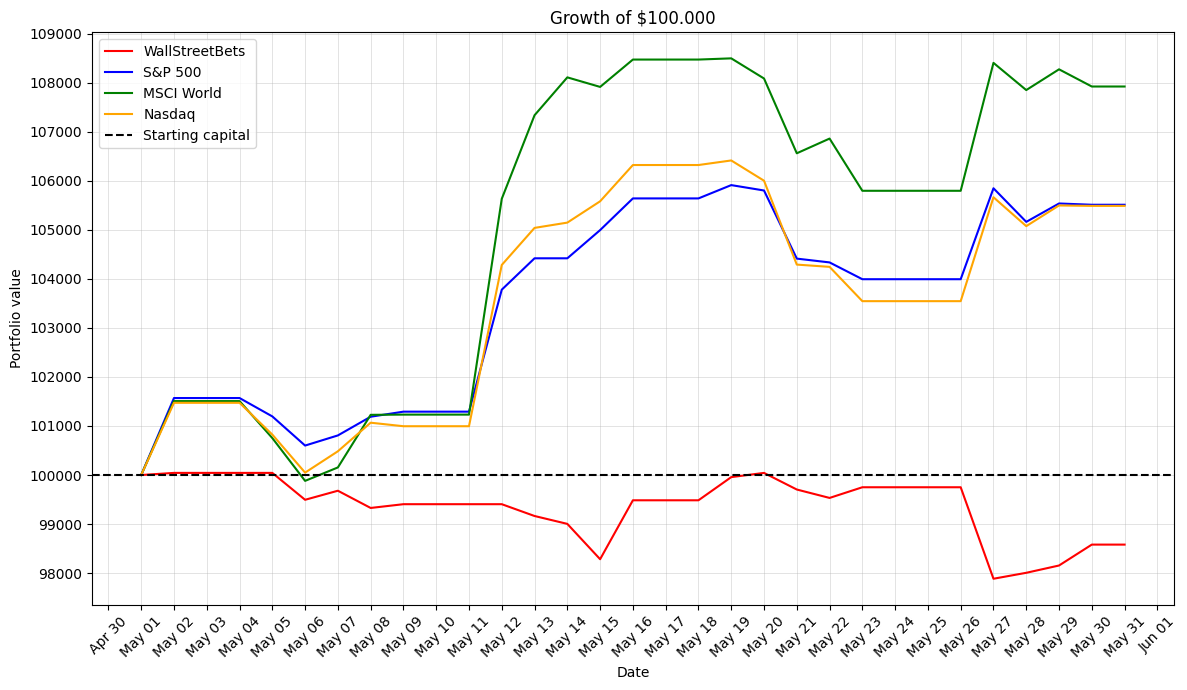

In [66]:
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

# Equity curves plot
plt.figure(figsize=(12,7))
ax = plt.gca()
strategy_eq.plot(label="WallStreetBets", color='red', ax=ax)
bench_eq['S&P 500'].plot(label="S&P 500", color='blue', ax=ax)
bench_eq['MSCI World'].plot(label="MSCI World", color='green', ax=ax)
bench_eq['Nasdaq'].plot(label="Nasdaq", color='orange', ax=ax)
start_capital = 100_000 
ax.axhline(y=start_capital, color='black', linewidth=1.5, linestyle='--', label='Starting capital')
plt.title("Growth of $100.000")
plt.ylabel("Portfolio value")
plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.5)

# Set y-axis ticks spaced every 1000 units
ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))

# Use a DayLocator to include all dates and a DateFormatter for English short date names
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

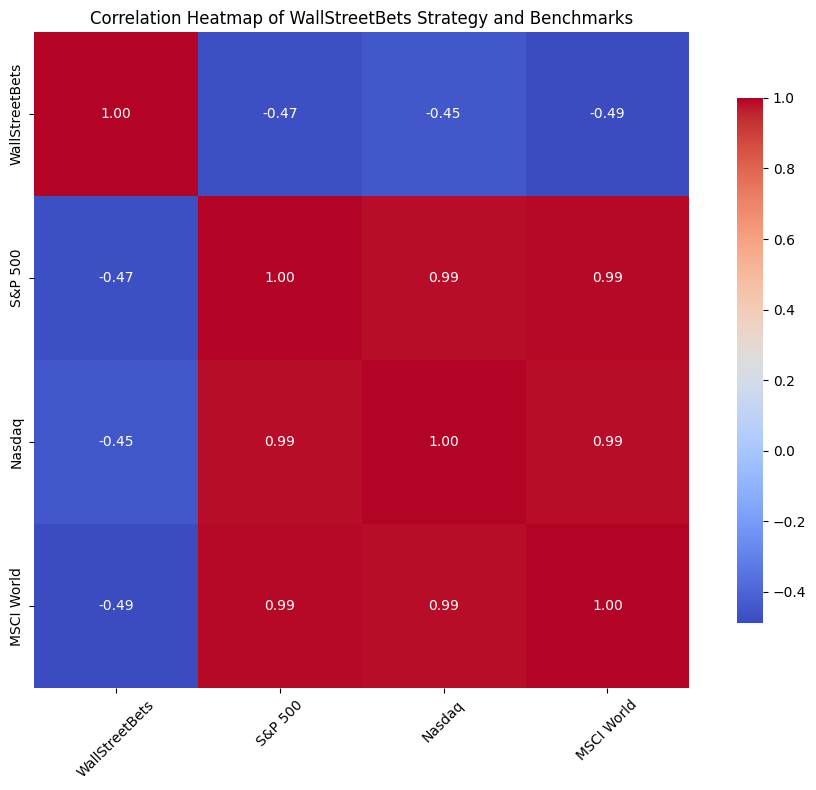

In [67]:
combined_df = pd.concat([strategy_eq, bench_eq],axis=1)
combined_df.columns = ['WallStreetBets', 'S&P 500', 'Nasdaq', 'MSCI World']

# Heatmap correlation matrix of the wallstreetbets strategy and the benchmarks
def plot_correlation_heatmap(combined_df):
    # Calculate the correlation matrix
    corr_matrix = combined_df.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(10, 8))
    
    # Create a heatmap with annotations
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    
    # Set the title and labels
    plt.title('Correlation Heatmap of WallStreetBets Strategy and Benchmarks')
    plt.xticks(rotation=45)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function to plot the correlation heatmap
plot_correlation_heatmap(combined_df)